# EX 3 using TF

## Set up

In [25]:
# # install packages
# !pip install jiwer
# !pip install pandas
# !pip install matplotlib
# !pip install tensorflow-io

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

import torch
device = torch.device("cpu")

from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


%matplotlib inline

## Data Prep
### Load Data

In [27]:
data_path = "/home/ryanwhetten/Downloads/LJSpeech-1.1"
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ020-0052,Cut this into round cakes with a biscuit-cutte...
1,LJ023-0007,"I am reminded of that evening in March, four y..."
2,LJ043-0096,"became involved in conflicts, some of which we..."


### Split Data

In [28]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


### Character ↔️ Number Function

In [29]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [30]:
# print(tf.config.list_physical_devices('GPU'))


### Data encoding function
takes in a pice of audio and a trancript and outputs a spectrogram of the audio with the encoded transcript

In [65]:
from tensorflow.python.ops.gen_spectral_ops import fft
# int. scalar tensor. window length in samples
frame_length = 256
# int. scalar tensor. number of samples to step
frame_step = 160
# int scalar tensor. size of FFT
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float, this step might not be necessary
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, 
        frame_length=frame_length, 
        frame_step=frame_step, 
        fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [66]:
encode_single_sample(metadata_df.file_name[0], metadata_df.normalized_transcription[0])


(<tf.Tensor: shape=(990, 193), dtype=float32, numpy=
 array([[-0.15025406,  0.14391603,  1.345798  , ..., -0.9854204 ,
         -0.6269577 , -0.5236996 ],
        [-1.0030622 ,  2.4312236 ,  3.8331764 , ..., -0.6904955 ,
         -0.6984013 , -0.9493723 ],
        [-1.2189028 , -1.0282376 , -0.8592111 , ..., -1.2561305 ,
         -1.3919637 , -1.4885381 ],
        ...,
        [ 0.46195787,  1.4432973 ,  1.8151202 , ..., -0.71081823,
         -0.7552238 , -0.80150014],
        [ 1.8990719 ,  2.5526102 ,  2.8158083 , ..., -0.8588901 ,
         -0.8737249 , -0.8581365 ],
        [-0.05678392,  1.4547379 ,  2.2037091 , ..., -0.97084236,
         -1.1494601 , -1.0661962 ]], dtype=float32)>,
 <tf.Tensor: shape=(107,), dtype=int64, numpy=
 array([ 3, 21, 20, 30, 20,  8,  9, 19, 30,  9, 14, 20, 15, 30, 18, 15, 21,
        14,  4, 30,  3,  1, 11,  5, 19, 30, 23,  9, 20,  8, 30,  1, 30,  2,
         9, 19,  3, 21,  9, 20,  0,  3, 21, 20, 20,  5, 18, 30, 15, 18, 30,
         1, 30, 19,  8,  1, 1

### Create dataset objects

In [67]:
batch_size = 4

# define training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Checkout one sample

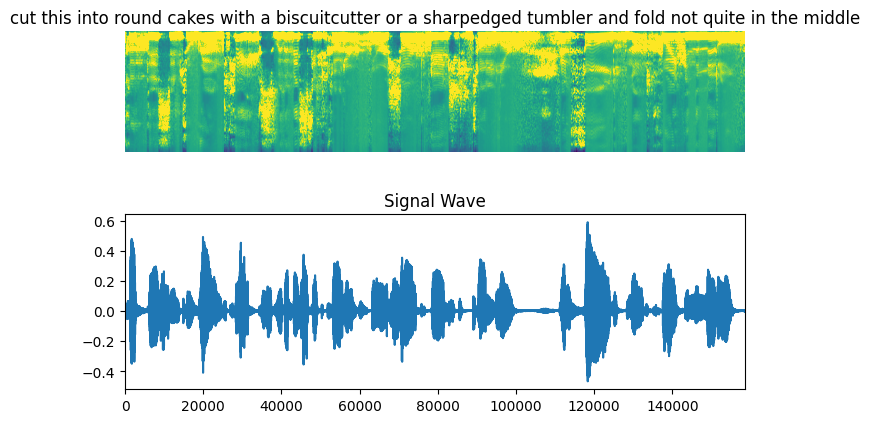

In [70]:
fig = plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

## Functions

In [76]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [77]:
# embeds and calculates cosine similarity
# returns matrix of all cosine similaritys
# between s and s1
def get_cos_sim(s, s1, model=minilm):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)


# get the diagonals of the cosine matrix
def get_respective_cos_sim(s, s1, model=minilm):
    cos_sim = get_cos_sim(s, s1, model)
    return cos_sim.diagonal()

# smoothing relu so that there will never be
# log of negative number or 0
def relu(x):
    return np.maximum(0.000001,x)

# custom cosine loss
# the negative log of the cosine similarity
def get_cos_loss(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((4,1))
    return -np.log(cos_sim).numpy()

# decodes set of label
def get_labels(y):
    gt = []
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    return gt

In [78]:
# Normal CTCLoss function
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [79]:
def CTC_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + cos_loss

## Model

In [81]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, loss=CTCLoss):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=loss, run_eagerly=True)
#     model.compile(optimizer=opt, loss=loss)
    
    return model




In [ ]:
model_base = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTCLoss,
)

In [82]:
model_cos = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTC_Cosine_Loss,
    
)

In [83]:
# model_cos.summary()

In [84]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
#         avg_cos_dis = get_avg_cos_dis(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
#         print(f"Avg. Cos Dis: {avg_cos_dis:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
#             print(f"Avg. Cos Dis: {get_avg_cos_dis(targets[i], predictions[i]):.4f}")
            print("-" * 100)
            
            

## Training

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_base.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_cos.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

2023-02-09 11:27:57.461770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-09 11:28:02.885401: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-09 11:28:06.773679: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.75GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
   1/2948 [..............................] - ETA: 22:52:23 - loss: 1333.1697

2023-02-09 11:28:22.766656: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   2/2948 [..............................] - ETA: 3:15:45 - loss: 1055.6703 

2023-02-09 11:28:26.850191: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   3/2948 [..............................] - ETA: 3:43:26 - loss: 892.8758 

2023-02-09 11:28:31.894522: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   4/2948 [..............................] - ETA: 3:44:14 - loss: 774.6057

2023-02-09 11:28:36.503457: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   5/2948 [..............................] - ETA: 3:41:48 - loss: 721.6926

2023-02-09 11:28:40.904911: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   6/2948 [..............................] - ETA: 3:47:29 - loss: 684.7618

2023-02-09 11:28:45.993200: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   7/2948 [..............................] - ETA: 3:48:59 - loss: 651.7643

2023-02-09 11:28:50.837441: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   8/2948 [..............................] - ETA: 3:48:37 - loss: 620.8909

2023-02-09 11:28:55.455138: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   9/2948 [..............................] - ETA: 3:48:27 - loss: 594.6392

2023-02-09 11:29:00.076326: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  91/2948 [..............................] - ETA: 3:15:04 - loss: 351.4582

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model_base.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
    break
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)
